In [ ]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!pip install kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d slothkong/10-monkey-species
!unzip 10-monkey-species

In [2]:
import torch
from torchvision import transforms
from PIL import Image

def get_tensor_image_from_path(path):
    img = Image.open(path).resize((256, 256))
    convert_tensor = transforms.ToTensor()
    convert_tensor.requires_grad=True
    return convert_tensor(img)

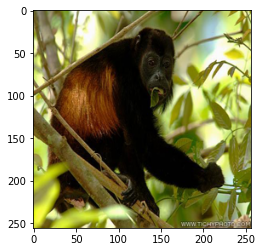

In [3]:
import matplotlib.pyplot as plt

plt.imshow(get_tensor_image_from_path('/content/training/training/n0/n0018.jpg').permute(1,2,0))

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [5]:
from torch.utils.data import Dataset, DataLoader 
import os

class MonkeyDataset(Dataset):
    def __init__(self, path):
        self.path = path
        self.images_pathes = []
        for directory in os.listdir(path):
            for file_name in os.listdir(path + directory + "/"):
                self.images_pathes.append((int(directory[-1]), path + directory + "/" + file_name))

    def __len__(self):
        return len(self.images_pathes)

    def __getitem__(self, index):
        return {
            'X' : get_tensor_image_from_path(self.images_pathes[index][1]).to(device),
            'y' : torch.LongTensor([self.images_pathes[index][0]]).to(device)
        }

In [6]:
train_dataset = MonkeyDataset('/content/training/training/')
valid_dataset = MonkeyDataset('/content/validation/validation/')

train_loader = DataLoader(train_dataset, batch_size = 10, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size = 10, shuffle=True)

for batch in train_loader:
    print(batch['X'].shape, batch['y'].shape)
    break

torch.Size([10, 3, 256, 256]) torch.Size([10, 1])


## Model

In [7]:
import torch.nn as nn 

class ImageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.1),
            nn.Conv2d(64, 64, 4, 2, 1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.1),
            nn.Conv2d(64, 64, 4, 2, 1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.1),
            nn.Conv2d(64, 16, 4, 2, 1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.1),
            nn.Conv2d(16, 8, 4, 2, 1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
        self.softmax = nn.Softmax()
    def forward(self, X):
        hidden = self.model(X)
        output = self.softmax(hidden)
        return output

## Simple adversarial attacks:

In [8]:
!pip install torchattacks

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 105 kB 25.9 MB/s 


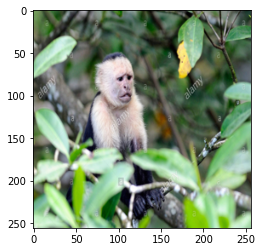

In [9]:
sample_model = ImageModel()
plt.imshow(train_dataset[0]['X'].permute(1,2,0).cpu());

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


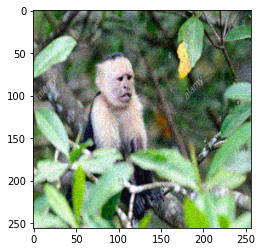

In [10]:
from torchattacks import FGSM

attack = FGSM(sample_model, eps=0.07)
modified_image = attack(train_dataset[0]['X'].unsqueeze(0), train_dataset[0]['y'])
plt.imshow(modified_image.squeeze(0).permute(1,2,0).detach().cpu());

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


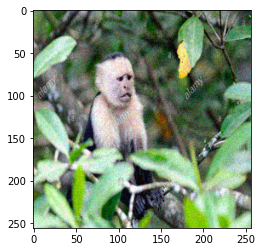

In [11]:
from torchattacks import PGD

attack = PGD(sample_model, eps=15/255, alpha=15/255, steps=40, random_start=True)
modified_image = attack(train_dataset[0]['X'].unsqueeze(0), train_dataset[0]['y'])
plt.imshow(modified_image.squeeze(0).permute(1,2,0).detach().cpu())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


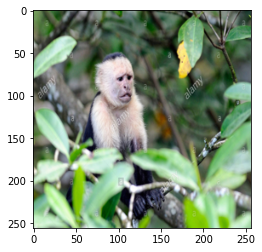

In [12]:
from torchattacks import CW

attack = CW(sample_model, c=1e-4, kappa=0, steps=1000, lr=0.01)
modified_image = attack(train_dataset[0]['X'].unsqueeze(0), train_dataset[0]['y'])
plt.imshow(modified_image.squeeze(0).permute(1,2,0).detach().cpu())

## Comparing base and robust models

In [13]:
@torch.no_grad()
def get_valid_score(model, sklearn_metric):
    model.eval()
    preds = None
    target = None
    for batch in valid_loader:
        output = model(batch['X'])
        output = torch.argmax(output, dim=1)
        if preds is not None:
            preds = torch.cat([preds, output])
            target = torch.cat([target, batch['y']])
        else:
            preds = output
            target = batch['y']
    return sklearn_metric(target.reshape(-1).cpu().detach().numpy(), preds.reshape(-1).cpu().detach().numpy())

In [14]:
base_model = ImageModel().to(device)
optimizer = torch.optim.Adam(base_model.parameters(), lr = 1e-3)
criterion = nn.CrossEntropyLoss()

In [16]:
from tqdm.auto import tqdm 

n_epochs = 10
base_model.train()
for epoch in tqdm(range(n_epochs)):
    for batch in train_loader:
        optimizer.zero_grad()
        output = base_model(batch['X'])
        loss = criterion(output, batch['y'].squeeze())
        loss.backward()
        optimizer.step()    

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [17]:
robust_model = ImageModel().to(device)
optimizer = torch.optim.Adam(robust_model.parameters(), lr = 1e-3)
criterion = nn.CrossEntropyLoss()

In [18]:
from tqdm.auto import tqdm 

n_epochs = 10
robust_model.train()

attacks = [FGSM(robust_model, eps=0.07), PGD(robust_model, eps=15/255, alpha=15/255, steps=40, random_start=True),
           CW(robust_model, c=1e-4, kappa=0, steps=10, lr=0.01)]

for epoch in tqdm(range(n_epochs)):
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        output = robust_model(batch['X'])
        loss = criterion(output, batch['y'].squeeze())
        for attack in attacks:
            attacked_image = attack(batch['X'],  batch['y'].squeeze())
            output = robust_model(attacked_image)
            loss += criterion(output, batch['y'].squeeze())
        loss.backward()
        optimizer.step()    

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

In [19]:
import pandas as pd 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df_results = pd.DataFrame({
    'model_type' : ['base', 'robust'],
    'accuracy_score' : [get_valid_score(base_model, accuracy_score), get_valid_score(robust_model, accuracy_score)],
})
df_results

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


,model_type,accuracy_score
0,base,0.408088
1,robust,0.437500


## Detector

In [22]:
class Detector(nn.Module):
    def __init__(self, base, robust):
        super().__init__()
        self.base = base
        for param in self.base.parameters():
            param.requires_grad_(False)
        self.robust = robust
        for param in self.robust.parameters():
            param.requires_grad_(False)
        self.fc_net = nn.Sequential(
            nn.Linear(20, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 4),
            nn.ReLU(),
            nn.Linear(4, 1),
            nn.Sigmoid()
        )
    def forward(self, X):
        output1 = self.base.model(X)
        output2 = self.robust.model(X)
        output = torch.cat([output1, output2], 1)
        return self.fc_net(output)

In [23]:
detector = Detector(base_model, robust_model).to(device)
optimizer = torch.optim.Adam(detector.parameters(), lr = 1e-3)
criterion = nn.BCELoss()

In [26]:
from tqdm.auto import tqdm 

n_epochs = 10
robust_model.train()

attacks = [FGSM(robust_model, eps=0.07), PGD(robust_model, eps=15/255, alpha=15/255, steps=40, random_start=True),
           CW(robust_model, c=1e-4, kappa=0, steps=10, lr=0.01)]

for epoch in tqdm(range(n_epochs)):
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        output = detector(batch['X'])
        loss = criterion(output, torch.zeros(batch['y'].shape).to(device))
        for attack in attacks:
            attacked_image = attack(batch['X'], batch['y'].squeeze())
            output = detector(attacked_image)
            loss += criterion(output, torch.ones(batch['y'].shape).to(device))
        loss.backward()
        optimizer.step()    

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

In [33]:
sum_acc, cnt_acc = 0, 0
for batch in tqdm(valid_loader):
    output = detector(batch['X'])
    sum_acc += (output < 0.7).sum()
    cnt_acc += output.shape[0]
    for attack in attacks:
        attacked_image = attack(batch['X'], batch['y'].squeeze())
        output = detector(attacked_image)
        sum_acc += (output > 0.7).sum()
        cnt_acc += output.shape[0]

print(f"Mean accuracy on validation if {sum_acc / cnt_acc}")

  0%|          | 0/28 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Mean accuracy on validation if 0.6893382668495178
